<a href="https://colab.research.google.com/github/ashkanfarhangi/AI-for-Trading/blob/master/Improved_Evolution_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/UCF_Intelligent Systems/data/Google1819.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1048.339966,1066.939941,1045.229980,1065.000000,1065.000000,1237600
1,2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1082.479980,1430200
2,2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1086.400024,1004600
3,2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1102.229980,1279100
4,2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1106.939941,1047600


In [3]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.9.0
pandas==0.24.2
numpy==1.16.3
matplotlib==3.0.3
google==2.0.2


# Deep Evolution Strategy:

In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]
#Prediction used to update the weights
    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision
#Weights are being updated after each iteration
    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        portfolio = []
        investmentPortfolio =[]
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                portfolio.append(initial_money)
                states_buy.append(t)
                
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                portfolio.append(initial_money)
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                    investmentPortfolio.append(invest)
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, portfolio ,investmentPortfolio

#Training

In [0]:
#Tweaking goes here
#w 30 ,i 12k,l 300 > S = 36 48
#w 30 ,i 12k,l 300 > S = 29 38 2.5k=54

In [7]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 12000

model = Model(input_size = window_size, layer_size = 300, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 20000, checkpoint = 100)

iter 100. reward: 29.040501
iter 200. reward: 38.376419
iter 300. reward: 44.428920
iter 400. reward: 48.836587
iter 500. reward: 48.593253
iter 600. reward: 50.398918
iter 700. reward: 50.820669
iter 800. reward: 52.081168
iter 900. reward: 52.260417
iter 1000. reward: 52.237917
iter 1100. reward: 51.731169
iter 1200. reward: 51.902337
iter 1300. reward: 53.944837
iter 1400. reward: 54.263586
iter 1500. reward: 53.712837
iter 1600. reward: 54.275418
iter 1700. reward: 53.618250
iter 1800. reward: 51.725669
iter 1900. reward: 54.174421
iter 2000. reward: 54.240170
iter 2100. reward: 54.355752
iter 2200. reward: 51.225753
iter 2300. reward: 54.781086
iter 2400. reward: 53.564336
iter 2500. reward: 54.358752
iter 2600. reward: 54.368502
iter 2700. reward: 51.001584
iter 2800. reward: 54.822335
iter 2900. reward: 54.786501
iter 3000. reward: 54.286919
iter 3100. reward: 55.218751
iter 3200. reward: 54.722835
iter 3300. reward: 55.442585
iter 3400. reward: 55.025587
iter 3500. reward: 53.4

In [0]:
i

In [8]:
states_buy, states_sell, total_gains, invest,portfolio,investmentPortfolio = agent.buy()


day 0: buy 1 unit at price 1065.000000, total balance 10935.000000
day 1, sell 1 unit at price 1082.479980, investment 1.641313 %, total balance 12017.479980,
day 19: buy 1 unit at price 1163.689941, total balance 10853.790039
day 20, sell 1 unit at price 1169.939941, investment 0.537085 %, total balance 12023.729980,
day 22: buy 1 unit at price 1111.900024, total balance 10911.829956
day 23: buy 1 unit at price 1055.800049, total balance 9856.029907
day 24: buy 1 unit at price 1080.599976, total balance 8775.429931
day 25: buy 1 unit at price 1048.579956, total balance 7726.849975
day 26: buy 1 unit at price 1001.520020, total balance 6725.329955
day 27: buy 1 unit at price 1037.780029, total balance 5687.549926
day 29: buy 1 unit at price 1052.099976, total balance 4635.449950
day 30: buy 1 unit at price 1069.699951, total balance 3565.749999
day 32, sell 1 unit at price 1094.800049, investment -1.537906 %, total balance 4660.550048,
day 33: buy 1 unit at price 1102.459961, total bal

#Results:

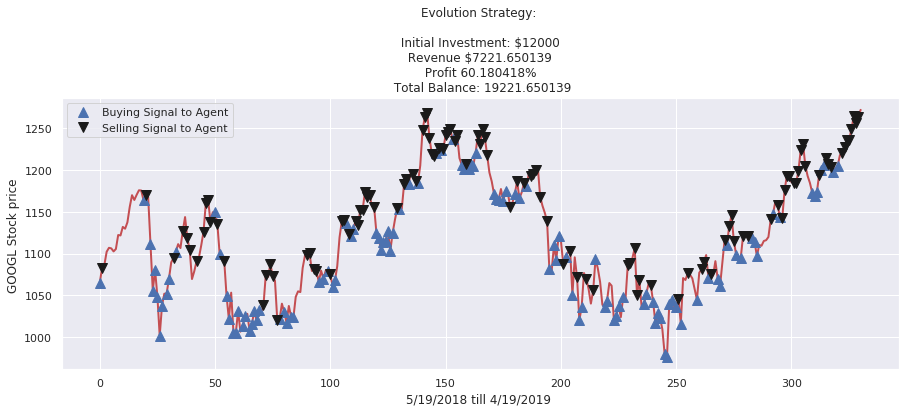

In [9]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='b', label = 'Buying Signal to Agent', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'Selling Signal to Agent', markevery = states_sell)
plt.title('Evolution Strategy: \n \n Initial Investment: $12000 \n Revenue $%f \n Profit %f%% \n Total Balance: %f'%(total_gains, invest,portfolio[-1]))
plt.legend()
plt.ylabel('GOOGL Stock price ') 
plt.xlabel('5/19/2018 till 4/19/2019 ') 

plt.show()

In [0]:
portfolio = pd.DataFrame(portfolio)
investmentPortfolio = pd.DataFrame(investmentPortfolio)
rollingMeanInvest = investmentPortfolio.rolling(window=10).mean()
rollingMeanPort = portfolio.rolling(window=10).mean()


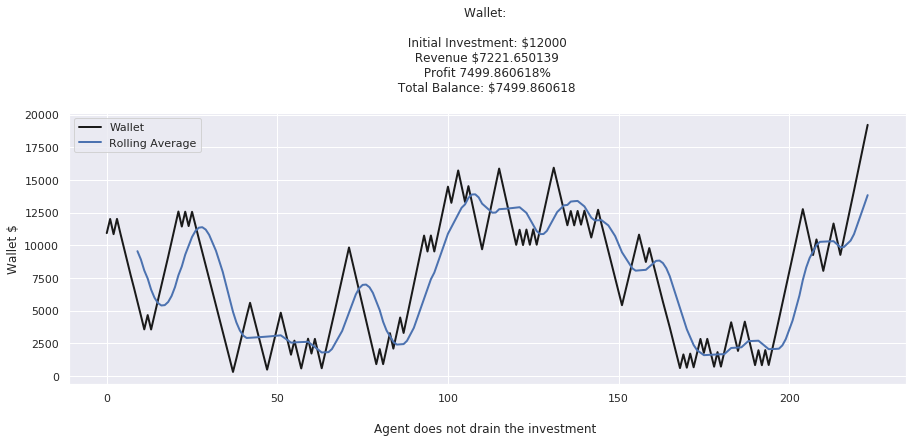

In [11]:
fig = plt.figure(figsize = (15,5))

plt.plot(portfolio, color='k',label = "Wallet", lw=2.)
plt.plot(rollingMeanPort,color='b',label = "Rolling Average", lw=2.)
plt.title('Wallet: \n \n Initial Investment: $12000 \n Revenue $%f \n Profit %f%% \n Total Balance: $%f \n'%(total_gains, portfolio.mean(),portfolio.mean()))
plt.legend()
plt.ylabel('Wallet $') 
plt.xlabel('\nAgent does not drain the investment ')
plt.show()


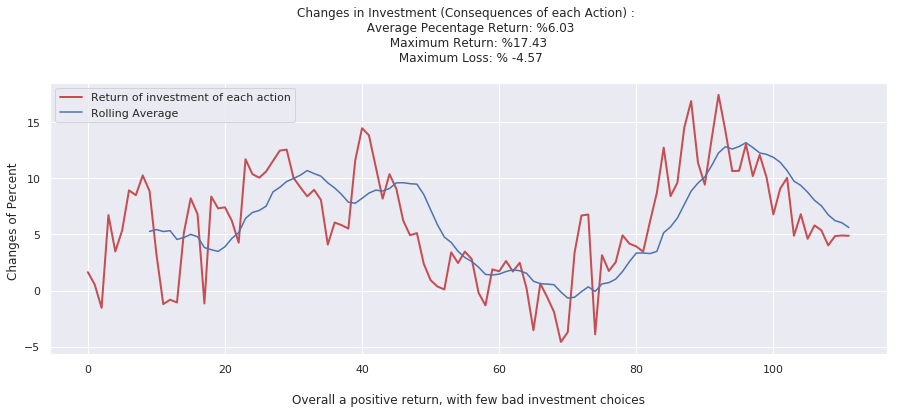

In [15]:
fig = plt.figure(figsize = (15,5))
rollingMean = investmentPortfolio.rolling(window=10).mean()
plt.plot(investmentPortfolio, label = 'Return of investment of each action', color='r', lw=2.)
plt.plot(rollingMean,label = "Rolling Average")
#plt.plot(close, '^', markersize=10, color='b', label = 'Buying Signal to Agent', markevery = states_buy)
plt.title('Changes in Investment (Consequences of each Action) : \n  Average Pecentage Return: %%%.2f \n Maximum Return: %%%.2f \n Maximum Loss: %% %.2f\n'%(investmentPortfolio.mean(),investmentPortfolio.max(),investmentPortfolio.min()))

plt.legend()
plt.ylabel('Changes of Percent ') 
plt.xlabel('\nOverall a positive return, with few bad investment choices') 

plt.show()

In [13]:
investmentPortfolio.describe()

,0
count,112.000000
mean,6.034873
std,4.797104
min,-4.573347
25%,2.610455
50%,5.946639
75%,9.721950
max,17.434005


References:

https://arxiv.org/abs/1703.03864    

https://github.com/openai/evolution-strategies-starter